# Deep Learning
## Practice Projects
# P2 Additional: Noise Reduction for Multi-Label Classification
## Style and Libraries

In [1]:
%%html
<style>
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: aliceblue;} 
a {color: #4876ff; font-family: 'Roboto';} 
h1 {color: #348ABD; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Roboto'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #348ABD; font-family: 'Orbitron';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #4876ff;}      
div.output_stderr pre {background-color: aliceblue;}  
div.output_stderr {background-color: slategrey;}                        
</style>
<script>
code_show = true; 
function code_display() {
    if (code_show) {
        $('div.input').each(function(id) {
            if (id == 0 || $(this).html().indexOf('hide_code') > -1) {$(this).hide();}
        });
        $('div.output_prompt').css('opacity', 0);
    } else {
        $('div.input').each(function(id) {$(this).show();});
        $('div.output_prompt').css('opacity', 1);
    };
    code_show = !code_show;
} 
$(document).ready(code_display);
</script>
<form action="javascript: code_display()">
<input style="color: #348ABD; background: aliceblue; opacity: 0.8;" \ 
type="submit" value="Click to display or hide code cells">
</form>                 

In [123]:
hide_code = ''
import numpy as np 
import pandas as pd
import math

import tensorflow as tf

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

import h5py
import cv2

from keras.models import Sequential, load_model, Model
from keras.layers import Input, UpSampling2D
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

## Step 1. Load and Explore the Data

In [179]:
hide_code
# Read the h5 file
f = h5py.File('LetterColorImages3.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [180]:
hide_code
# Create tensors and targets
backgrounds = np.array(f[keys[0]])
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (9540, 32, 32, 3)
Target shape (9540,)
Background shape: (9540,)


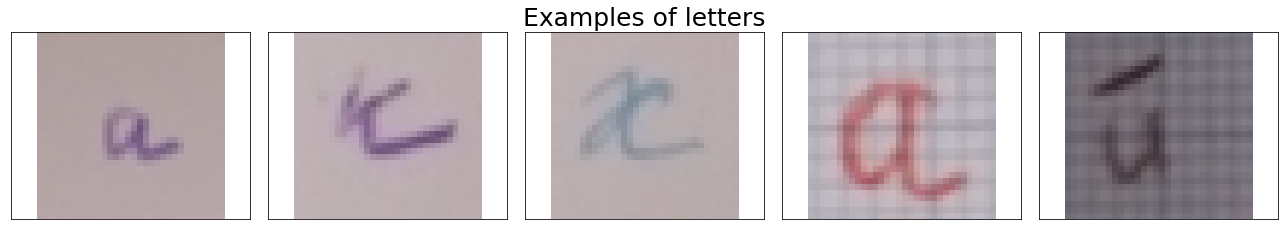

In [181]:
hide_code
# Plot letter images
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = tensors[i*2000]/255
    ax[i].imshow(image)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of letters', fontsize=25);

## Step 2. Preprocess

In [182]:
hide_code
# Normalize the tensors
tensors = tensors.astype('float32')/255

In [183]:
hide_code
# Grayscaled tensors
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
gray_tensors = gray_tensors.reshape(-1, 32, 32, 1)
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (9540, 32, 32, 1)


In [184]:
hide_code
# One-hot encode the targets, started from the zero label
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(9540, 33)

In [185]:
hide_code
# One-hot encode the background targets
backgrounds = to_categorical(backgrounds-2,2)
backgrounds.shape

(9540, 2)

In [186]:
hide_code
# Create multi-label targets
back_targets = np.concatenate((cat_targets, backgrounds), axis=1)
back_targets.shape

(9540, 35)

In [187]:
hide_code
# Split the grayscaled data
x_train, x_test, y_train, y_test = train_test_split(gray_tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [188]:
hide_code
# Split the grayscaled data
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

## Step 3. Create Neural Networks for Noise Reduction
#### TensorFlow; Less Compressed Images

In [189]:
hide_code
# NN for noise reduction

inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 32x32x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 16x16x32
conv2 = tf.layers.conv2d(maxpool1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 16x16x16
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 8x8x16
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 8x8x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (8,8))
# Now 8x8x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 8x8x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (16,16))
# Now 16x16x16
conv5 = tf.layers.conv2d(upsample2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 16x16x16
upsample3 = tf.image.resize_nearest_neighbor(conv5, (32,32))
# Now 32x32x16
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 32x32x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
# Now 32x32x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [190]:
hide_code
# Function for creating batches
def get_batches(images, batch_size):
    current_index = 0
    while current_index + batch_size <= images.shape[0]:
        data_batch = images[current_index:current_index + batch_size]
        current_index += batch_size
        yield data_batch    

In [191]:
hide_code
# Define parameters
epochs = 100
batch_size = 64
train_step = 0

In [192]:
hide_code
# Run the tensorflow session 
sess = tf.Session()
sess.run(tf.global_variables_initializer())
gray_tensors1 = np.copy(gray_tensors)

for e in range(epochs):
    for batch_images in get_batches(gray_tensors1, batch_size):
        train_step += 1
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: batch_images,
                                                         targets_: batch_images})
        if train_step % 200 == 0:
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Training loss: {:.4f}".format(batch_cost))

Epoch: 2/100... Training loss: 0.6332
Epoch: 3/100... Training loss: 0.6765
Epoch: 5/100... Training loss: 0.6876
Epoch: 6/100... Training loss: 0.6865
Epoch: 7/100... Training loss: 0.6636
Epoch: 9/100... Training loss: 0.6309
Epoch: 10/100... Training loss: 0.6238
Epoch: 11/100... Training loss: 0.6310
Epoch: 13/100... Training loss: 0.6809
Epoch: 14/100... Training loss: 0.6240
Epoch: 15/100... Training loss: 0.5932
Epoch: 17/100... Training loss: 0.6779
Epoch: 18/100... Training loss: 0.6797
Epoch: 19/100... Training loss: 0.6389
Epoch: 21/100... Training loss: 0.6736
Epoch: 22/100... Training loss: 0.6602
Epoch: 23/100... Training loss: 0.6260
Epoch: 25/100... Training loss: 0.6159
Epoch: 26/100... Training loss: 0.6238
Epoch: 27/100... Training loss: 0.6402
Epoch: 29/100... Training loss: 0.6167
Epoch: 30/100... Training loss: 0.6235
Epoch: 31/100... Training loss: 0.6369
Epoch: 33/100... Training loss: 0.6241
Epoch: 34/100... Training loss: 0.6204
Epoch: 35/100... Training loss:

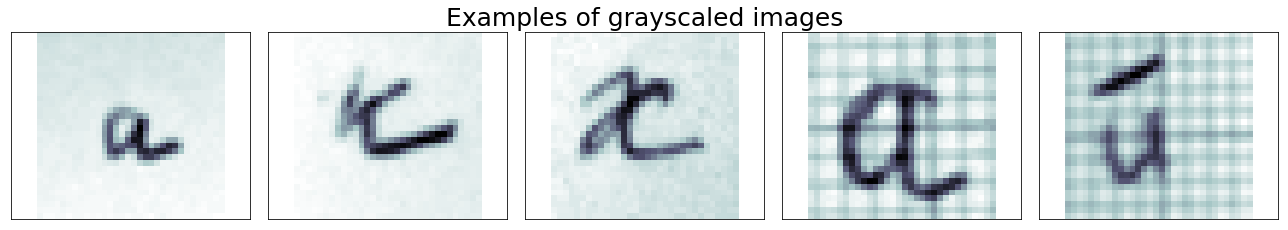

In [193]:
hide_code
# Display original grayscaled images
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = gray_tensors[i*2000].reshape(32,32)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of grayscaled images', fontsize=25);

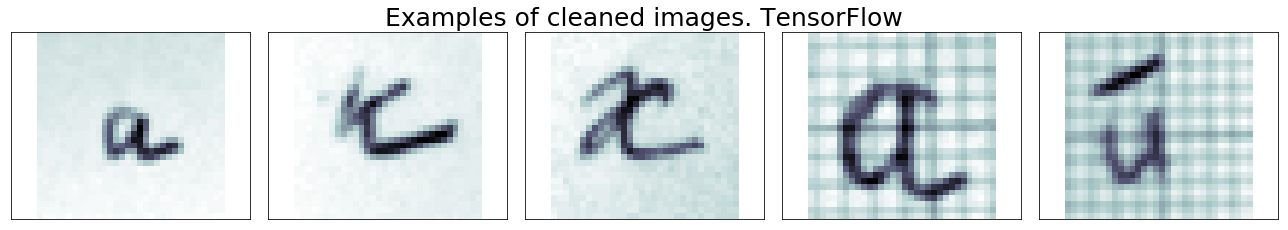

In [194]:
hide_code
# Display output grayscaled images
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = gray_tensors1[i*2000].reshape(32,32)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of cleaned images. TensorFlow', fontsize=25);

#### Keras; More Compressed Images

In [195]:
hide_code
def autoencoder():
    inputs = Input(shape=(32, 32, 1))
    
    # Encode
    x = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    x = MaxPooling2D(padding='same')(x)
    
    x = Conv2D(16, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(padding='same')(x)
    
    x = Conv2D(8, 3, activation='relu', padding='same')(x)
    encoded = MaxPooling2D(padding='same')(x)    
    
    # Decode
    x = Conv2D(8, 3, activation='relu', padding='same')(encoded)
    x = UpSampling2D()(x)
    
    x = Conv2D(16, 3, activation='relu', padding='same')(x)
    x = UpSampling2D()(x)
    
    x = Conv2D(32, 3, activation='relu', padding='same')(x) 
    x = UpSampling2D()(x)
    
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    # Autoencoder
    autoencoder = Model(inputs, decoded)
    
    # Compile
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    
    return autoencoder

autoencoder = autoencoder()

In [196]:
hide_code
# Display autoencoder architecture 
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_120 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 8, 8, 16)          0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 8, 8, 8)           1160      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 4, 4, 8)           0         
__________

In [197]:
# Train autoencoder
autoencoder_history = autoencoder.fit(x_train, x_train, 
                                      epochs=100, batch_size=64, 
                                      validation_data=(x_valid, x_valid))

Train on 7632 samples, validate on 954 samples
Epoch 1/100
7632/7632 [==============================] - 60s - loss: 0.6610 - val_loss: 0.6512
Epoch 2/100
7632/7632 [==============================] - 35s - loss: 0.6459 - val_loss: 0.6477
Epoch 3/100
7632/7632 [==============================] - 35s - loss: 0.6451 - val_loss: 0.6474
Epoch 4/100
7632/7632 [==============================] - 36s - loss: 0.6448 - val_loss: 0.6474
Epoch 5/100
7632/7632 [==============================] - 38s - loss: 0.6446 - val_loss: 0.6471
Epoch 6/100
7632/7632 [==============================] - 36s - loss: 0.6445 - val_loss: 0.6469
Epoch 7/100
7632/7632 [==============================] - 36s - loss: 0.6444 - val_loss: 0.6468
Epoch 8/100
7632/7632 [==============================] - 37s - loss: 0.6443 - val_loss: 0.6468
Epoch 9/100
7632/7632 [==============================] - 37s - loss: 0.6443 - val_loss: 0.6466
Epoch 10/100
7632/7632 [==============================] - 36s - loss: 0.6442 - val_loss: 0.6466
Ep

7632/7632 [==============================] - 40s - loss: 0.6433 - val_loss: 0.6456
Epoch 86/100
7632/7632 [==============================] - 45s - loss: 0.6432 - val_loss: 0.6456
Epoch 87/100
7632/7632 [==============================] - 37s - loss: 0.6432 - val_loss: 0.6456
Epoch 88/100
7632/7632 [==============================] - 43s - loss: 0.6432 - val_loss: 0.6456
Epoch 89/100
7632/7632 [==============================] - 44s - loss: 0.6432 - val_loss: 0.6456
Epoch 90/100
7632/7632 [==============================] - 42s - loss: 0.6432 - val_loss: 0.6456
Epoch 91/100
7632/7632 [==============================] - 39s - loss: 0.6432 - val_loss: 0.6456
Epoch 92/100
7632/7632 [==============================] - 39s - loss: 0.6432 - val_loss: 0.6456
Epoch 93/100
7632/7632 [==============================] - 36s - loss: 0.6432 - val_loss: 0.6455
Epoch 94/100
7632/7632 [==============================] - 38s - loss: 0.6432 - val_loss: 0.6456
Epoch 95/100
7632/7632 [=============================

In [198]:
hide_code
# Create decoded images
x_test_decoded = autoencoder.predict(x_test)

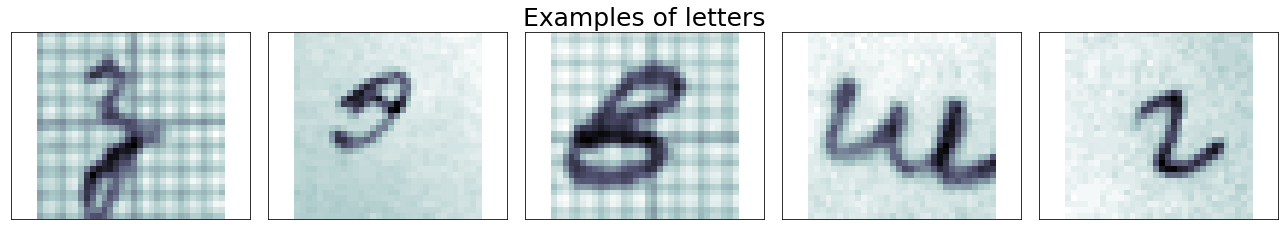

In [199]:
hide_code
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = x_test[i*100].reshape(32,32)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of letters', fontsize=25);

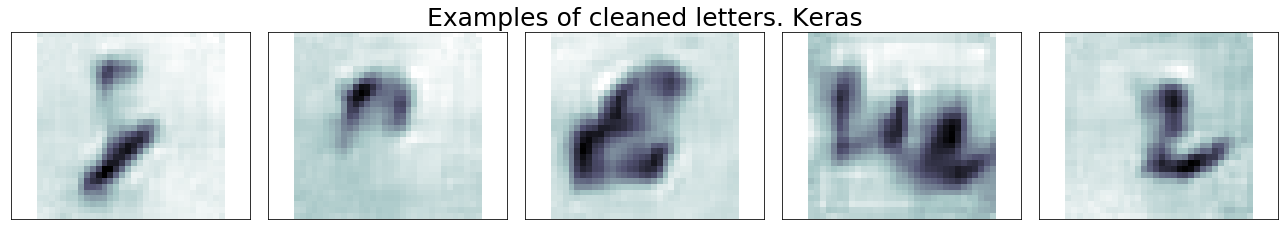

In [200]:
hide_code
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = x_test_decoded[i*100].reshape(32,32)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of cleaned letters. Keras', fontsize=25);